In [2]:
import pandas as pd
import numpy as np
import pandas as pd
from haversine import haversine, Unit
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier


In [3]:
df = pd.read_csv("/workspaces/Emiliano0041-IntroML/data/raw/diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
(df == 0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- No hay valores nulos, y todos los datos que tenemos son numericos.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


- Aqui me di cuenta que no es fisiologicamente posible que el resultado de la muestra de glucosa y de insulina den 0, por lo que elimine las muestras, y ya que son variables muy relevantes para mi estudio, y que al tener un dato erroneo podrian perjudicar mi prediccion

In [7]:
df_drop = df[df["Glucose"]>0]
df_drop = df[df["Insulin"]>0]
df_drop


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1
...,...,...,...,...,...,...,...,...,...
753,0,181,88,44,510,43.3,0.222,26,1
755,1,128,88,39,110,36.5,1.057,37,1
760,2,88,58,26,16,28.4,0.766,22,0
763,10,101,76,48,180,32.9,0.171,63,0


---

- En este data set, df_moda, esta el data set que contiene la moda en los datos que eran 0 en las variables Glucose e Insulin.

- La variable Insulin presento una curiosidad y fue que la moda de esta misma, tambien es 0. Por lo que tuve que sacar la moda de los valores distintos a 0 y asignarselos a una nueva variable, para luego reemplazar los 0 por esta nueva moda.

> Recalco que no estoy de acuerdo con este metodo, pero lo estoy probando.

In [8]:
df_moda = df.copy()
df_moda["Glucose"].replace(0, df["Glucose"].mode()[0], inplace=True)
moda_insulin = df[df["Insulin"] != 0]["Insulin"].mode()[0]
df_moda["Insulin"].replace(0, moda_insulin, inplace=True)
df_moda


/tmp/ipykernel_2787/66450503.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_moda["Glucose"].replace(0, df["Glucose"].mode()[0], inplace=True)
/tmp/ipykernel_2787/66450503.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,105,33.6,0.627,50,1
1,1,85,66,29,105,26.6,0.351,31,0
2,8,183,64,0,105,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,105,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,105,30.1,0.349,47,1


---

- Y ahora en df_knn tenemos el data set con todos los datos de "Glucose" e "Insuline", primero hemos remplazado los 0 por Nan y luego hemos reemplazado los 0 por el promedio de los valores de las filas similares, con el Imputador K-Nearest Neighbors (KNN) 


In [9]:
df_knn = df.copy()
df_knn[["Glucose", "Insulin"]] = df_knn[["Glucose", "Insulin"]].replace(0,np.nan)

imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = imputer.fit_transform(df_knn)
df_knn = pd.DataFrame(df_knn_imputed, columns=df.columns)
df_knn



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,169.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,58.6,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,0.0,188.4,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,0.0
764,2.0,122.0,70.0,27.0,165.0,36.8,0.340,27.0,0.0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,0.0
766,1.0,126.0,60.0,0.0,151.2,30.1,0.349,47.0,1.0


- Considero que todas las variables son importantes para el estudio de prediccion, por lo que no eliminare ninguna


---

<Axes: >

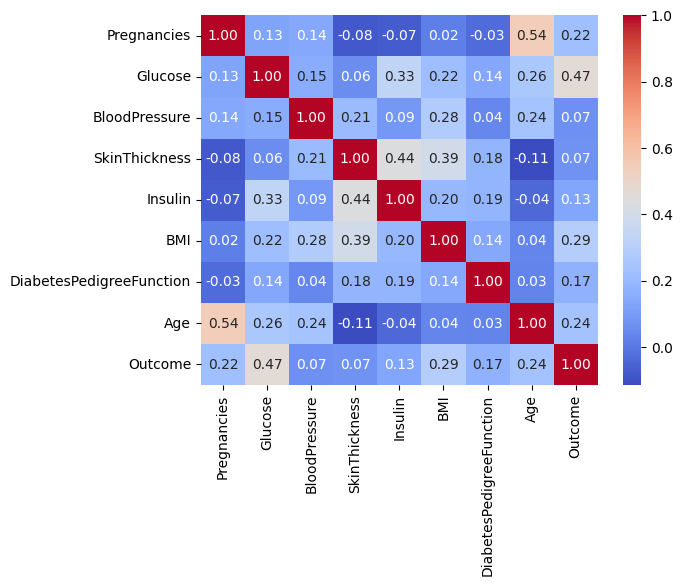

In [10]:
sns.heatmap(df[["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]].corr(),
             annot=True, fmt=".2f", cmap= "coolwarm" )

> Conclusion del heatmap

- Podemos observar que nuestra variable objetivo esta bastante correlacionada con columnas "Pregnancies", "Glucose", "Insulin", "BMI", "DiabetesPedigreeFunction" y "Age"

---

[Text(0, 0.5, '')]

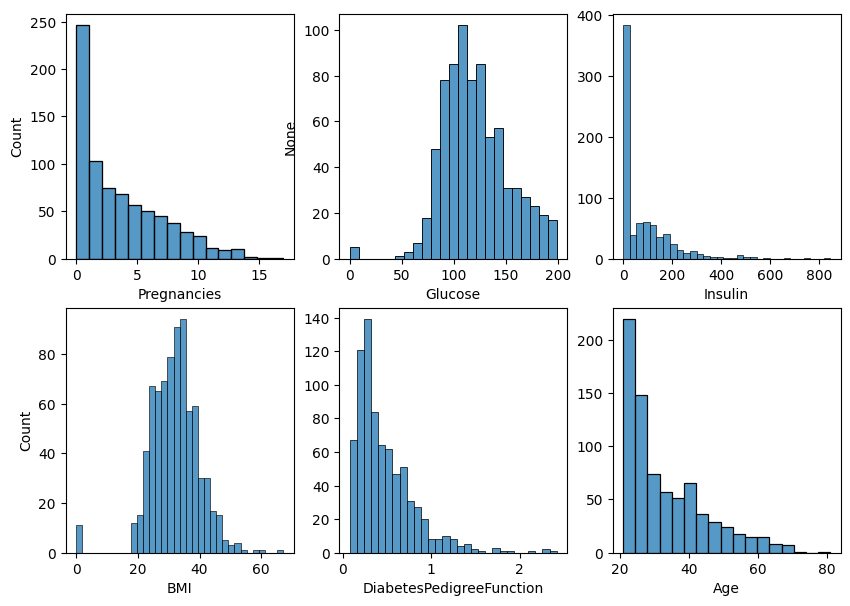

In [11]:
fig, axis = plt.subplots(2, 3, figsize = (10, 7))


sns.histplot(ax=axis[0, 0], data=df, x="Pregnancies")
sns.histplot(ax=axis[0, 1], data=df, x="Glucose").set(ylabel="None")
sns.histplot(ax=axis[0, 2], data=df, x="Insulin").set(ylabel=None)
sns.histplot(ax=axis[1, 0], data=df, x="BMI")
sns.histplot(ax=axis[1, 1], data=df, x="DiabetesPedigreeFunction").set(ylabel=None)
sns.histplot(ax=axis[1, 2], data=df, x="Age").set(ylabel=None)


- Aqui podemos apreciar distintos histogramas con datos numericos, que nos indican como varian las variables de la muestra total.

----

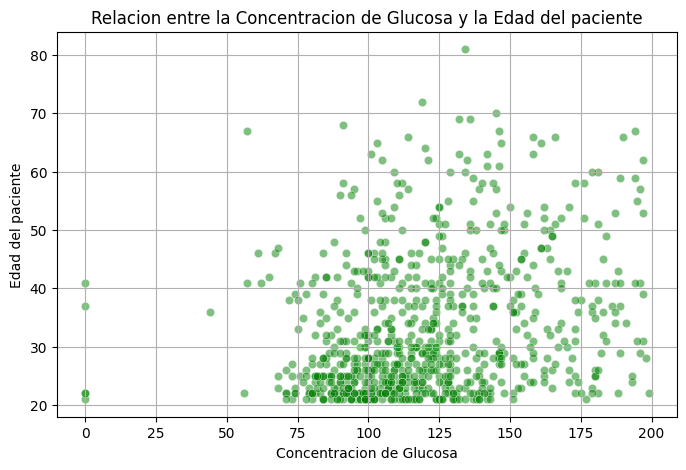

In [12]:
plt.figure(figsize=(8,5))
sns.scatterplot(df, x="Glucose", y="Age", color="g", alpha=0.5)
plt.title("Relacion entre la Concentracion de Glucosa y la Edad del paciente")
plt.xlabel("Concentracion de Glucosa")
plt.ylabel("Edad del paciente")
plt.grid(True)

- Podemos analizar que el aumento de la glucosa en sangre esta levemente relacionada con el paso del tiempo, a personas con mayor edad.

In [13]:
corr_outcome = df.corr()['Outcome'].drop('Outcome').abs().sort_values(ascending=False)
corr_outcome

Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

----

<Axes: xlabel='Outcome', ylabel='Insulin'>

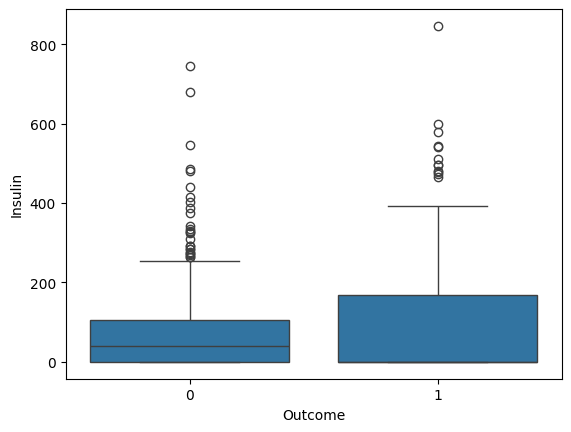

In [14]:
sns.boxplot(x="Outcome", y="Insulin", data=df)


- En el boxplot observado podemos ver que hay algunos Outliers en ambos casos de "Si" y "No" para diabetes. Como en el caso de casi 800 de insulina para alguien que no tiene diabetes, y alguien que tiene mas de 800 de insulina y si tiene diabetes.

<Axes: xlabel='Outcome', ylabel='Glucose'>

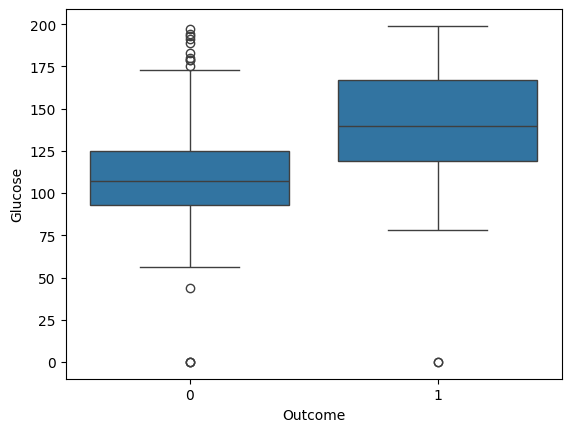

In [15]:
sns.boxplot(x="Outcome", y="Glucose", data=df)


- En este caso encontramos que los Outliers se encuentran del lado de las personas que dieron negativo al estudio de Diabetes, siendo curiosos los resultados por encima de 175 en concentracion de glucosa en personas "sanas"

---

> Split con df_drop

In [16]:
variables = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

X = df_drop.drop("Outcome", axis=1)[variables]
y = df_drop["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=22)


---

- Creacion del modelo

In [17]:
modelo_arbol = DecisionTreeClassifier(random_state=22)

- Entrenamos el modelo

In [18]:
modelo_arbol.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,22
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


- Hacemos predicciones

In [19]:
y_pred = modelo_arbol.predict(X_test)


- Medimos el accurancy

In [20]:
accurancy = accuracy_score(y_test, y_pred)
accurancy

0.7974683544303798

- Visualizamos el report

In [21]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.85      0.86        59
           1       0.59      0.65      0.62        20

    accuracy                           0.80        79
   macro avg       0.73      0.75      0.74        79
weighted avg       0.80      0.80      0.80        79



- Matriz de confusion

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[50,  9],
       [ 7, 13]])

---

> Ahora realizaremos los mismos pasos pero con los df_moda

- Split con df_moda

In [23]:
X = df_moda.drop("Outcome", axis=1)[variables]
y = df_moda["Outcome"]

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=22)


- Entrenamos el modelo con df_moda

In [24]:
modelo_arbol.fit(X_train_m, y_train_m)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,22
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


- Predecimos con df_moda

In [25]:
y_pred_m = modelo_arbol.predict(X_test_m)
y_pred_m


array([1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1])

In [26]:
accurancy_m = accuracy_score(y_test_m, y_pred_m)
accurancy_m

0.7272727272727273

In [27]:
report = classification_report(y_test_m, y_pred_m)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.82      0.80       100
           1       0.62      0.56      0.59        54

    accuracy                           0.73       154
   macro avg       0.70      0.69      0.69       154
weighted avg       0.72      0.73      0.72       154



-----


> Ahora lo realizaremos con el df_knn

- Split con df_knn

In [28]:
X = df_knn.drop("Outcome", axis=1)[variables]
y = df_knn["Outcome"]

X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=22)


- Entrenamos con df_knn

In [29]:
modelo_arbol_knn = DecisionTreeClassifier(random_state=22)

In [30]:
modelo_arbol_knn.fit(X_train_k, y_train_k)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,22
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


- Predecimos con df_knn

In [31]:
y_pred_k = modelo_arbol.predict(X_test_k)
y_pred_k


array([1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0])

In [32]:
accurancy_k = accuracy_score(y_test_k, y_pred_k)
accurancy_k

0.7207792207792207

In [33]:
report = classification_report(y_test_k, y_pred_k)
print(report)

              precision    recall  f1-score   support

         0.0       0.77      0.82      0.79       100
         1.0       0.62      0.54      0.57        54

    accuracy                           0.72       154
   macro avg       0.69      0.68      0.68       154
weighted avg       0.71      0.72      0.72       154



- Guardare todo y lo abrire en el archivo de (predict) en el cual hare de nuevo los pasos de predicciones pero solo con el df_drop, ya que fue el que mejor accuracy me da.

In [34]:
train = {"X_train" : X_train,
         "y_train" : y_train}
test ={"X_test" : X_test,
       "y_test" : y_test}
modelo = {"modelo" : modelo_arbol}

ruta = "/workspaces/Emiliano0041-IntroML/data/processed/"


with open(ruta + "train04.pkl", "wb") as f:
    pickle.dump(train, f)

with open(ruta + "test04.pkl", "wb") as f:
    pickle.dump(test, f)

with open(ruta + "modelo04.pkl", "wb") as f:
    pickle.dump(modelo, f)

In [36]:
train_k = {"X_train_k" : X_train_k, 
            "y_train_k"  : y_train_k}
test_k = {"X_test_k" : X_test_k,
            "y_test_k" : y_test_k}

ruta = "/workspaces/Emiliano0041-IntroML/data/processed/"

with open(ruta + "train_k04.pkl", "wb") as f:
    pickle.dump(train_k, f)

with open(ruta + "test_k04.pkl", "wb") as f:
    pickle.dump(test_k, f)